In [ ]:
#loading data from google drive if using collab
#this code has been written to run on colab using google drive
#There will 2 lines of code whenever data is required to be loaded, the default uncommented line runs on colab
#There will be a commented line with the relative path in case you download the folder from the git repo and run it locally
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/

In [ ]:
#basics
import numpy as np
import pandas as pd

#misc
import gc
import time
import warnings


#visualisations
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 

import json

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

%matplotlib inline

##EDA and Visualisations

In [ ]:
#this dataset contains information about all restaurants

business=pd.read_csv("/mydrive/DA_project/data/all_restaurants.csv")
#business=pd.read_csv("./data/all_restaurants.csv")

In [ ]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = int(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

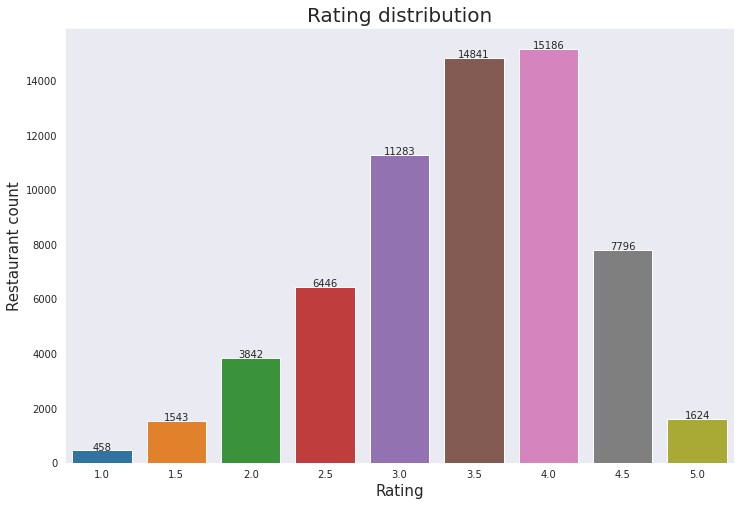

In [ ]:
#Rating vs Restaurant count
rating_distribution=business['stars'].value_counts()
rating_distribution=rating_distribution.sort_index()
plt.figure(figsize=(12,8))
ax=sns.barplot(rating_distribution.index,rating_distribution.values)
plt.title("Rating distribution",fontsize=20)
plt.ylabel("Restaurant count", fontsize=15)
plt.xlabel("Rating", fontsize=15)
show_values_on_bars(ax)
plt.show()

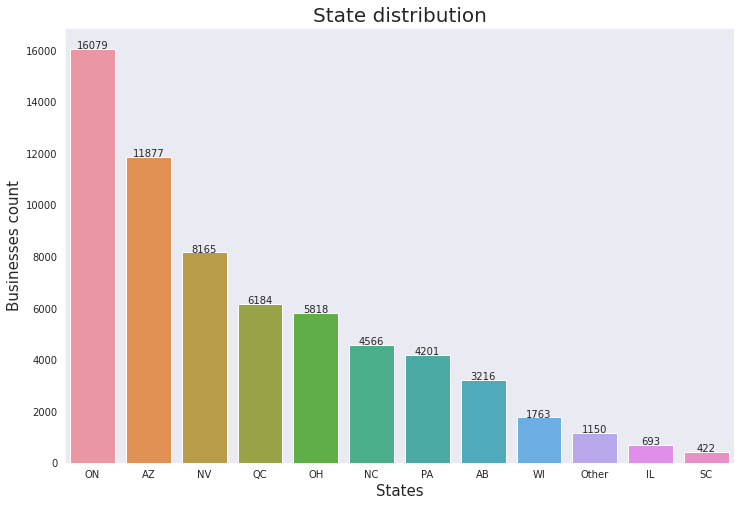

In [ ]:
#Distribution of restaurants across various states
state_distribution=business['state'].value_counts()
count=0
for i in state_distribution.index:
    if state_distribution[i] <1000:
        count+=state_distribution[i]
other=pd.Series([count],index=["Other"])
state_distribution=state_distribution.add(other, fill_value=0)

state_distribution=state_distribution.sort_values(ascending=False)
state_distribution=state_distribution.iloc[:12]
plt.figure(figsize=(12,8))
ax=sns.barplot(state_distribution.index,state_distribution.values)
plt.title("State distribution", fontsize=20)
plt.ylabel("Businesses count", fontsize=15)
plt.xlabel("States", fontsize=15)
show_values_on_bars(ax)
plt.show()

(-0.5, 7.5, 0.0, 34.65)

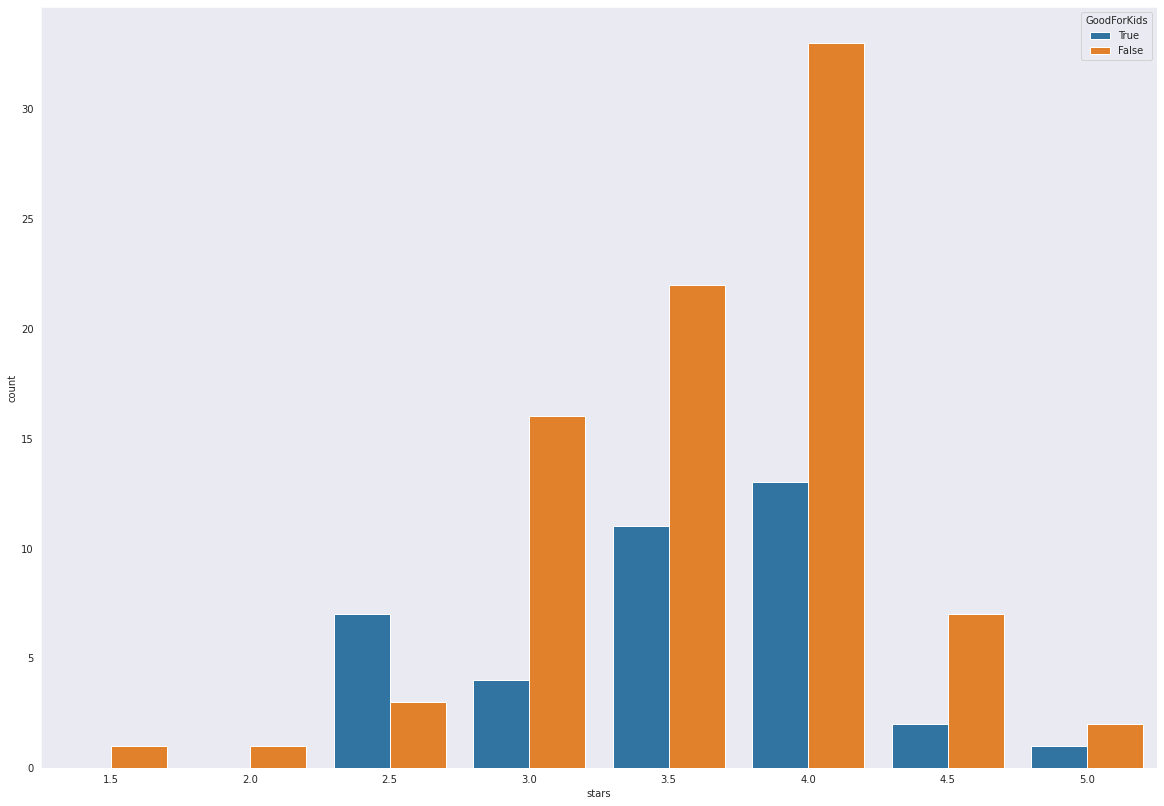

In [ ]:
#Plot to check how many restuarants allow smoking and are marked good for kids
f, ax = plt.subplots(figsize=(20, 14))
df_smoking = business[(business["Smoking"] == "Yes") & (business["GoodForKids"]!='None')]
fig = sns.countplot("stars", hue = "GoodForKids", data = df_smoking)
fig.axis()

(-0.5, 8.5, 0.0, 8923.95)

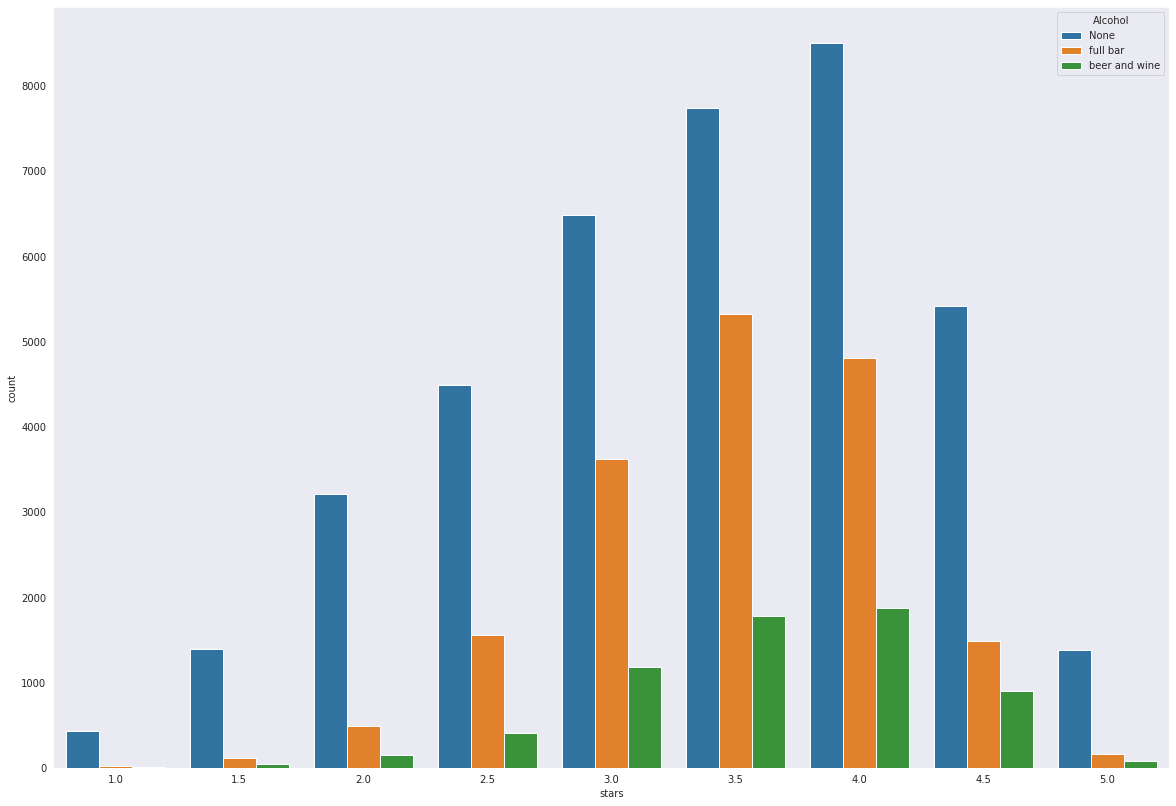

In [ ]:
#Plot to check distribution of alcohol vs stars
f, ax = plt.subplots(figsize=(20, 14))
fig = sns.countplot("stars", hue = "Alcohol", data = business)
fig.axis()

(-0.5, 3.5, 0.0, 8113.35)

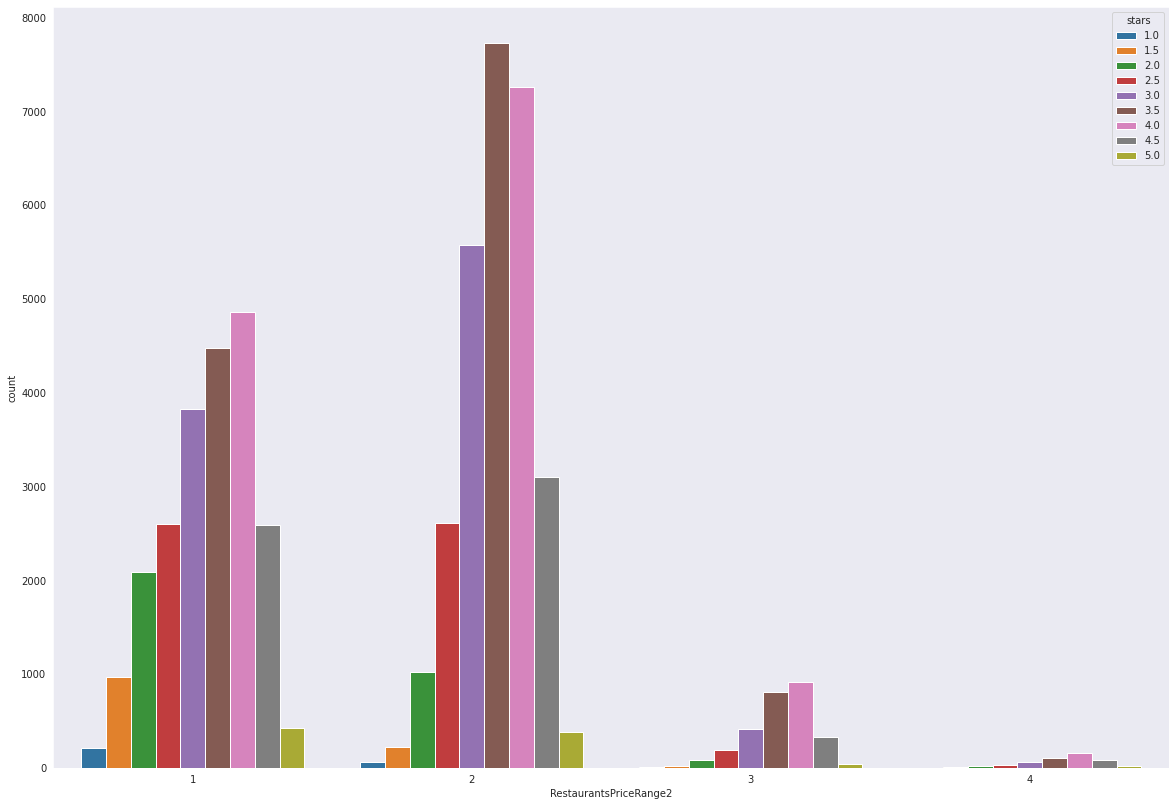

In [ ]:
#Plot to show distribution of restaurant count vs price range with stars as hue
f, ax = plt.subplots(figsize=(20, 14))
fig = sns.countplot("RestaurantsPriceRange2", hue = "stars", data = business[business.RestaurantsPriceRange2!='None'])
fig.axis()

In [ ]:
rating_data=business[['latitude','longitude','stars','review_count']]
rating_data['popularity']=rating_data['stars']*rating_data['review_count']

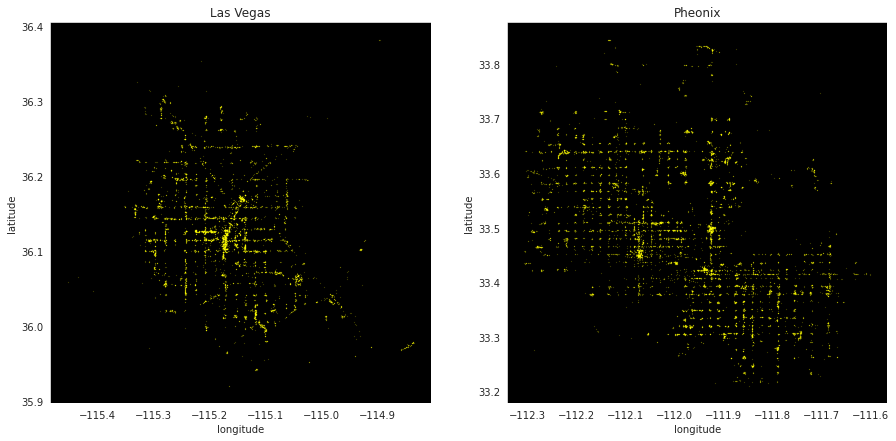

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

#a random point inside vegas
lat = 36.207430
lon = -115.268460
#some adjustments to get the right pic
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5
#subset for vegas
ratings_data_vegas=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]

#Facet scatter plot
ratings_data_vegas.plot(kind='scatter', x='longitude', y='latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Las Vegas")
ax1.set_facecolor('black')

#a random point inside pheonix
lat = 33.435463
lon = -112.006989
#some adjustments to get the right pic
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5
#subset for pheonix
ratings_data_pheonix=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]
#plot pheonix
ratings_data_pheonix.plot(kind='scatter', x='longitude', y='latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Pheonix")
ax2.set_facecolor('black')
f.show()

##Content Based Recommender System

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_name_from_id(index, df):
  return df[df.index==index]["name"].values[0]

def get_index_from_name(name,df):
  return df[df.name==name]["index"].values[0]

def create_subset_df(state, city):
  df_new=df_restaurant[(df_restaurant.state==state) & (df_restaurant.city==city)]
  df_new=df_new.drop(['index','Unnamed: 0'], 1)
  df_new.reset_index(inplace=True)
  return df_new
def combine_features(row):
  return (row["cat_1"]+" "+row["cat_2"]+" "+row["cat_3"]+" "+row["cat_4"]+" "+row["cat_5"]+" "+row["cat_6"]+" "+row["cat_7"]+" "+row["cat_8"]+" "+row["cat_9"]).strip()


In [ ]:
df_restaurant=pd.read_csv("/mydrive/DA_project/data/rest_Scottsdale_AZ.csv")
#df_restaurant=pd.read_csv("./data/rest_Scottsdale_AZ.csv")

In [ ]:
features_2=["city","state","cat_1","cat_2","cat_3","cat_4","cat_5","cat_6","cat_7","cat_8","cat_9","cat_10"]

In [ ]:
for column in features_2:
  df_restaurant[column]=df_restaurant[column].fillna('')

In [ ]:
df_restaurant.drop(['Unnamed: 0','Unnamed: 0.1','index','highlights','delivery or takeout', 'Grubhub enabled', 'Call To Action enabled',
       'Request a Quote Enabled', 'Covid Banner', 'Temporary Closed Until',
       'Virtual Services Offered','hours',
       'BusinessAcceptsCreditCards', 'BikeParking', 'GoodForKids',
       'BusinessParking', 'ByAppointmentOnly', 'RestaurantsPriceRange2',
       'No of attributes', 'DogsAllowed', 'WiFi', 'RestaurantsAttire',
       'RestaurantsTakeOut', 'NoiseLevel', 'RestaurantsReservations',
       'RestaurantsGoodForGroups', 'HasTV', 'Alcohol', 'RestaurantsDelivery',
       'OutdoorSeating', 'Caters', 'WheelchairAccessible', 'AcceptsInsurance',
       'RestaurantsTableService', 'Ambience', 'GoodForMeal', 'HappyHour',
       'BusinessAcceptsBitcoin', 'BYOB', 'Corkage', 'GoodForDancing',
       'CoatCheck', 'BestNights', 'Music', 'Smoking', 'DietaryRestrictions',
       'DriveThru', 'HairSpecializesIn', 'BYOBCorkage','AgesAllowed',
       'RestaurantsCounterService', 'Open24Hours'],axis=1,inplace=True)
df_restaurant.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10
0,WCOuyKKNHWqua5MAKUNpaQ,Dos Diablos,32527 N Scottsdale Rd,Scottsdale,AZ,85266,33.779790,-111.925770,2.0,16,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","American (New), Mexican, Sports Bars, Nightlif...",American (New),Mexican,Sports Bars,Nightlife,Bars,Restaurants,NaN,NaN,NaN,NaN
1,98zrbyncBdGRXQngWmSjOA,4th Floor Grille & Sports Bar,5001 N Scottsdale Rd,Scottsdale,AZ,85250,33.510059,-111.925592,4.0,40,0,"{'RestaurantsDelivery': 'False', 'Ambience': ""...","Nightlife, Restaurants, Food, American (Tradit...",Nightlife,Restaurants,Food,American (Traditional),Bars,Sports Bars,NaN,NaN,NaN,NaN
2,AcFmtQtWdV8NJuAORmBYiQ,BRKFST,4363 N 75th St,Scottsdale,AZ,85251,33.500169,-111.919817,3.0,36,0,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Asian Fusion, Hawaiian, Restaurants, Breakfast...",Asian Fusion,Hawaiian,Restaurants,Breakfast & Brunch,NaN,NaN,NaN,NaN,NaN,NaN
3,ivUQ3POcIceOW0S4tng5Aw,Slices Pizza,7111 E 5th Ave,Scottsdale,AZ,85251,33.498028,-111.927951,4.5,7,0,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","Restaurants, Pizza",Restaurants,Pizza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1Ai-ashfNW5nWgOqDars3g,HomeTown Buffet,1312 N Scottsdale Rd,Scottsdale,AZ,85257,33.462616,-111.926974,1.5,19,0,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","American (New), Breakfast & Brunch, Buffets, R...",American (New),Breakfast & Brunch,Buffets,Restaurants,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_restaurant.drop_duplicates(subset=['name'],inplace=True)
df_restaurant.reset_index(inplace=True)

In [ ]:
df_restaurant['combined_features']=df_restaurant.apply(combine_features, axis=1)

In [ ]:
cv=CountVectorizer()
count_matrix=cv.fit_transform(df_restaurant["combined_features"])

In [ ]:
cosine_sim=cosine_similarity(count_matrix)

In [ ]:
rest_index=get_index_from_name("Taco Bell",df_restaurant)
similar_rest=list(enumerate(cosine_sim[rest_index]))
sorted_similar_rest=sorted(similar_rest, key=lambda x: x[1], reverse=True)

In [ ]:
i=0
for res in sorted_similar_rest:
  print(get_name_from_id(res[0],df_restaurant))
  i=i+1
  if i>10:
    break

Taco Bell
Filiberto's Mexican Food
Chipotle Mexican Grill
El Pollo Loco
Jack in the Box
Someburros
Jalapeno Inferno
Los Olivos Mexican Patio
Barrio Queen
Spotted Donkey Cantina
Arizona Room Patio Grill


##Collaborative Filtering with PCC

In [ ]:
import pandas as pd
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df_reviews=pd.read_csv('/mydrive/DA_project/data/reviews_Scottsdale_AZ.csv')
df_reviews.drop_duplicates(inplace=True)
df_restaurant=pd.read_csv("/mydrive/Yelp/city_reviews/rest_Scottsdale_AZ.csv")

def get_similar_restaurants(rest_id,user_rating):
  similar_score=item_similarity_df[rest_id]*(user_rating-2.5)
  similar_score=similar_score.sort_values(ascending=False)
  return similar_score

def standardize(row):
  new_row=(row-row.mean()) /(row.max()-row.min())
  return new_row

In [ ]:
user_ratings=df_reviews.pivot_table(index=['user_id'],columns=['business_id'],values='stars')
user_ratings.head()

business_id,-01XupAWZEXbdNbxNg5mEg,-79cl_yASWXiv7RmzirNxA,-9nai28tnoylwViuJVrYEQ,-Ap4cG9Pqk9Lp6mFnBAqOg,-DcE_4T0_iRKGLARmjsjUw,-DnHJe6KzF2hRv8H2IQ78g,-F5mm0-YeCI7viSiOwVAAw,-FLnsWAa4AGEW4NgE8Fqew,-GUi0xyzwT9KJPS0v96dRA,-M6OV8aHvxMCFNmjP3B8vw,-MuatiMmslPOvk9kOMyjkA,-Oj_rs84KRFOTtbeQXPB7Q,-Vk9BMbpL2hcv4SZTuk4TA,-aqb_GgAbEIOdhbY0UDKog,-bd4BQcl1ekgo7avaFngIw,-dhuOV5E2-H0K39ez58K9A,-exEWEQ3iSMVC-QUP_ycPQ,-faYl3ejjjm7ciR_j1ke7A,-kzdfAFoqPpJU903Zt_aeA,-o082vExIs0VVNSuZmiTQA,-oDK9KnYMRwl5Mog46V1Sw,-s5zZEv5u9XWhx1i5E0_pA,-sYbz2nZY6iVFPd957E7dw,-vw3-EFSXYuNcRSr9SzwoA,-yWvniZVC6TjhnnptXRVrA,007FFjmDHkT9cLE6O4Cqxg,024QUHVU7nlyW5y2BeeGLg,04L9uKk6OixQ7ForUfPQLw,04ZtW6rq8rPYD-kLhNY2_Q,0BlfvOIiqur_kp3ba3dpFw,0DCRyiF8BoyXZOoStIdtAw,0Ekvh_EVMIKhKKEOLNodNA,0I0hxOcOLjKGIBUTG-G-dQ,0LKcSabd5Gd5oz-qrHTzZg,0OxEVzBKDmTP7GdSmhi3ow,0PFf3RKtDQyHnrdcPo8zMQ,0QiXMQroT9V6ByBLehufgw,0SdBUBJ7uBGj9bEJQgeXBA,0VOh4VIq13oFburRU9gddw,0W_pPAiTXgazY2mtX6o0_w,...,ypIzqbkJli_75hgFz98WiQ,ypQOqmkR3bl1kZI0C8H-Zg,yqYtY3-Po4OVPafA9Z-Xyw,yr7tfzFc88ciGvAwAypCqg,ysRrcDdb_sY9vnEFpneoFA,yt1C94WXeUokPsjyqWWaiQ,ytAsW7DYezxMMzqoO_-nIQ,ytoKWw50MfHs5PPEJtPjMQ,z4K95Y4P5nMrtJiDtXWDYA,z5TUgcA7lmicOxSpBx3QiQ,z83ABHR6E2N6eGLrm8OiEQ,z8Em-bhZI3Mmspml7tj6tg,z8lagvcw1Y4Pz4dVNRO48g,z9oJeVmNEc3F0ToZ0x4WuQ,zDbRhfmrhXdXy1o8uKTrAg,zEkDP9LpHKiy8AQcHECc4w,zFUsSyXtDqVkx5hNzN4-gg,zIOLoKIOXpGrzndARGhkAw,zK_8IIKiSXZUapswCEvsPg,zNm3C496tg-jcrvG5khRUg,zO_K6lnNFU2rVZGknB1ApQ,zPQesAWNB_FuL2Be1pPPlA,zWKpPyzm0W9N5OEPDuwgMA,za9qr9ZZWLTfEgTfogRbUw,zaotMgByfU9_RnxpTeqVeg,zcXIPwqjKWQ7H5EXkEZfkw,zcsBSu5ihIfaVSWIvdMRzQ,zfOum9_rEhaLAqoAV3nYaQ,zfeD4tImUPT8CznDrsn-mQ,zgAecXWgPlkthxKPR6Dtcg,znNyiHZs5TAX64WonjJ4dg,znr2_qMyy9SPi5UPfCFulA,zpC-0J9p7V26ZZAVses64A,zqNgwQjj0_XAll-neGikIw,zr93wrNyXzc-HW4IcK4iRQ,zrDi4gEaUi64lAMfJU51dw,zu7DiVAX0wO4f8rGPU8URg,zuVvDYJkKAbXQTTBauAqJQ,zvO-PJCpNk4fgAVUnExYAA,zyPGYeXF4XKCqNN1pjFWhg
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
---PLwSf5gKdIoVnyRHgBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--0m9EkntVYJ_91RuYfitg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--1UpCuUDJQbqiuFXkOzaw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--2HUmLkcNHZp0xw6AMBPg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--3B8LdT1NCD-bPkwS5-5g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_ratings.shape

(111254, 1587)

In [ ]:
#drop restaurants with less than 10 reviews/ratings
user_ratings=user_ratings.dropna(thresh=10, axis=1).fillna(0)

In [ ]:
#use cosine similarity or pearson correlation
#method 1 pearson correlation
item_similarity_df=user_ratings.corr(method='pearson')

In [ ]:
#method 2 cosine similarity
user_ratings=user_ratings.apply(standardize)
item_similarity=cosine_similarity(user_ratings.T) #remove T for user-user collaborative filtering
item_similarity_df=pd.DataFrame(item_similarity,index=user_ratings.columns, columns=user_ratings.columns)

In [ ]:
item_similarity_df.head()

business_id,-01XupAWZEXbdNbxNg5mEg,-79cl_yASWXiv7RmzirNxA,-9nai28tnoylwViuJVrYEQ,-Ap4cG9Pqk9Lp6mFnBAqOg,-DcE_4T0_iRKGLARmjsjUw,-F5mm0-YeCI7viSiOwVAAw,-FLnsWAa4AGEW4NgE8Fqew,-GUi0xyzwT9KJPS0v96dRA,-M6OV8aHvxMCFNmjP3B8vw,-MuatiMmslPOvk9kOMyjkA,-Oj_rs84KRFOTtbeQXPB7Q,-aqb_GgAbEIOdhbY0UDKog,-bd4BQcl1ekgo7avaFngIw,-dhuOV5E2-H0K39ez58K9A,-exEWEQ3iSMVC-QUP_ycPQ,-faYl3ejjjm7ciR_j1ke7A,-o082vExIs0VVNSuZmiTQA,-oDK9KnYMRwl5Mog46V1Sw,-s5zZEv5u9XWhx1i5E0_pA,-sYbz2nZY6iVFPd957E7dw,-vw3-EFSXYuNcRSr9SzwoA,-yWvniZVC6TjhnnptXRVrA,007FFjmDHkT9cLE6O4Cqxg,024QUHVU7nlyW5y2BeeGLg,04L9uKk6OixQ7ForUfPQLw,04ZtW6rq8rPYD-kLhNY2_Q,0DCRyiF8BoyXZOoStIdtAw,0I0hxOcOLjKGIBUTG-G-dQ,0OxEVzBKDmTP7GdSmhi3ow,0PFf3RKtDQyHnrdcPo8zMQ,0QiXMQroT9V6ByBLehufgw,0SdBUBJ7uBGj9bEJQgeXBA,0VOh4VIq13oFburRU9gddw,0W_pPAiTXgazY2mtX6o0_w,0ZK9asOntomBeXs0iSaW4Q,0a5jrIXBKH5aRtQzh728qg,0bF6jv97Z6VbruRpepUOcw,0d6kx6Jlocw77y1J9nbqMA,0gXYLVPNWz0WT8wXQVpS0g,0iVmcOx02Gxuo4kfcTK-2w,...,yQXnr78QZh4KUhgFw_cevQ,yUAwR_aC6QtSyjuJUhOEKQ,yXwD_uRBt598C2SBIvWRCg,yZAGhlsrmupLbrgdKm6reg,ydqbNz2sHENV9XOElwyAYA,ykb78lXHMHjNFBPVOL5meQ,ypIzqbkJli_75hgFz98WiQ,ypQOqmkR3bl1kZI0C8H-Zg,yqYtY3-Po4OVPafA9Z-Xyw,yr7tfzFc88ciGvAwAypCqg,ysRrcDdb_sY9vnEFpneoFA,yt1C94WXeUokPsjyqWWaiQ,ytAsW7DYezxMMzqoO_-nIQ,z4K95Y4P5nMrtJiDtXWDYA,z8Em-bhZI3Mmspml7tj6tg,z8lagvcw1Y4Pz4dVNRO48g,z9oJeVmNEc3F0ToZ0x4WuQ,zDbRhfmrhXdXy1o8uKTrAg,zEkDP9LpHKiy8AQcHECc4w,zFUsSyXtDqVkx5hNzN4-gg,zK_8IIKiSXZUapswCEvsPg,zNm3C496tg-jcrvG5khRUg,zPQesAWNB_FuL2Be1pPPlA,zWKpPyzm0W9N5OEPDuwgMA,za9qr9ZZWLTfEgTfogRbUw,zaotMgByfU9_RnxpTeqVeg,zcsBSu5ihIfaVSWIvdMRzQ,zfOum9_rEhaLAqoAV3nYaQ,zfeD4tImUPT8CznDrsn-mQ,zgAecXWgPlkthxKPR6Dtcg,znNyiHZs5TAX64WonjJ4dg,znr2_qMyy9SPi5UPfCFulA,zpC-0J9p7V26ZZAVses64A,zqNgwQjj0_XAll-neGikIw,zr93wrNyXzc-HW4IcK4iRQ,zrDi4gEaUi64lAMfJU51dw,zu7DiVAX0wO4f8rGPU8URg,zuVvDYJkKAbXQTTBauAqJQ,zvO-PJCpNk4fgAVUnExYAA,zyPGYeXF4XKCqNN1pjFWhg
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-01XupAWZEXbdNbxNg5mEg,1.000000,-0.000508,0.002650,-0.000313,-0.000377,0.004363,0.005145,-0.000409,-0.000652,0.027838,0.001633,0.008362,0.006529,0.028033,-0.000964,0.003986,0.004061,0.018113,0.004949,-0.000488,0.016885,0.017270,0.025783,0.010581,-0.000523,0.033291,-0.000391,0.014777,0.013889,0.012324,-0.000324,-0.000254,0.011919,0.015250,0.002950,0.000605,0.002193,0.020418,0.016685,-0.000508,...,0.036272,-0.000650,-0.000617,0.010239,0.019398,0.019657,-0.000268,0.006178,0.000632,-0.000475,-0.000256,-0.000914,0.015838,0.006985,0.038916,-0.000965,-0.000773,0.010416,0.004593,0.010178,0.046986,-0.000294,0.013516,0.017138,0.007968,-0.000388,-0.000288,-0.000860,-0.000242,0.014337,0.014781,0.005848,0.004849,0.004170,0.015736,0.020661,0.008283,0.072315,-0.000432,-0.001351
-79cl_yASWXiv7RmzirNxA,-0.000508,1.000000,-0.001126,-0.000169,-0.000204,-0.000781,0.009866,-0.000221,0.017378,0.013791,-0.000493,-0.000503,-0.000012,-0.000235,-0.000522,0.018058,-0.001135,-0.000207,-0.000689,-0.000264,-0.000593,-0.000388,-0.000174,-0.000820,-0.000283,-0.000591,-0.000211,-0.000334,-0.000320,-0.000790,-0.000176,-0.000137,-0.000547,0.014838,0.022130,-0.000264,0.010442,-0.000664,-0.001414,-0.000275,...,-0.000343,-0.000352,-0.000334,0.003909,-0.000984,-0.000197,-0.000145,0.009412,-0.001326,-0.000257,-0.000139,-0.000495,-0.000839,-0.001074,-0.000430,-0.000523,-0.000419,-0.000435,-0.000395,-0.000375,-0.000159,-0.000159,-0.000536,-0.000598,0.018476,-0.000210,-0.000156,-0.000465,-0.000131,-0.000570,-0.000533,0.006503,-0.000459,0.004048,-0.000832,-0.001215,-0.000215,-0.000787,-0.000234,-0.000731
-9nai28tnoylwViuJVrYEQ,0.002650,-0.001126,1.000000,-0.000694,-0.000835,0.013232,0.014214,-0.000907,-0.001446,0.004134,0.020266,0.009351,0.020294,0.009173,-0.000036,0.014416,0.013645,-0.000848,0.006923,-0.001083,0.009566,0.003329,0.018802,0.018563,-0.001159,0.000150,0.008262,0.001261,0.002748,0.009012,0.008838,-0.000562,0.023610,0.006258,0.004908,0.000786,0.003628,0.023325,0.031838,-0.001127,...,0.007227,-0.001442,0.013420,0.012737,0.009061,0.020576,-0.000594,

In [ ]:
#test code pretty generalized
mexican_lover = [("X-ZKjDFvlcBrSfukL39C9g",5),("5zRZ-h3iEXzjyad8gox39w",4),("AcFmtQtWdV8NJuAORmBYiQ",1),("cKgUCzMGuRgkbKXUsgeXUw",4)]
similar_rests=pd.DataFrame()

for rest,rating in mexican_lover:
  similar_rests=similar_rests.append(get_similar_restaurants(rest,rating),ignore_index=True)

similar_rests.head()
a=similar_rests.sum().sort_values(ascending=False)
for index in a.index[0:10]:
  print(df_restaurant.name[df_restaurant.business_id==index].values[0])

Taco Bell
Chipotle Mexican Grill
Barrio Queen
Subway Restaurants
Buffalo Wild Wings
Wendy's
Wendy's
Subway Restaurants
Subway Restaurants
McDonald's


##Collaborative Filtering with cosine similarity and evaluation metrics

In [ ]:
df=pd.read_csv("/mydrive/Yelp/city_reviews/reviews_Cleveland_OH.csv")

In [ ]:
df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1', 'review_id','useful','funny','cool','text','date'],axis=1,inplace=True)
df.head()

,user_id,business_id,stars
0,ica-FXNzyDzoOeArmg9Lwg,bM3ARXFMxGrntnHS6a7vEQ,5.0
1,ekO1FoeD8c9uqIQokBLCSQ,TKaND6oV1n2ylnCYoAfoag,5.0
2,DZEClXcmhoTk2caP9gpl5w,bM3ARXFMxGrntnHS6a7vEQ,5.0
3,xEKAb9TGx4aOGbHXSaCmDQ,K74HYkFjYwhEpJt8HTOxnQ,5.0
4,w9wic5DqY79J-qWfF7mYQw,4V2KN03EJMzaoOmLOy5UhQ,5.0


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(91923, 3)

In [ ]:
a=df.user_id.value_counts().sort_values(ascending=False)
df_2=a.to_frame()
df_2.rename(columns={'user_id':'user_count'}, inplace=True)
df_2=df_2[df_2.user_count>=10]

In [ ]:
df_2.shape

(1227, 1)

In [ ]:
index=df_2.index

In [ ]:
df=df[df.user_id.isin(index)]
df.reset_index(inplace=True)

In [ ]:
df.drop(['index'],axis=1,inplace=True)

In [ ]:
n_users=df.user_id.unique().shape[0]
n_items=df.business_id.unique().shape[0]
print(str(n_users)+' users')
print(str(n_items)+' items')

1227 users
1407 items


In [ ]:
def create_mapping(values, filename):
  with open(filename, 'w') as ofp:
    value_to_id={value:idx for idx,value in enumerate(values.unique())}
    for value, idx in value_to_id.items():
      idx=str(idx)
      ofp.write(value+','+idx+'\n')
    return value_to_id

user_mapping=create_mapping(df['user_id'], '/mydrive/DA_project/data/cf/users.csv')
item_mapping=create_mapping(df['business_id'], '/mydrive/DA_project/data/cf/items.csv')

In [ ]:
df['userId']=df['user_id'].map(user_mapping.get)
df['itemId']=df['business_id'].map(item_mapping.get)

In [ ]:
df=df[['userId','itemId','stars']]
df.to_csv("/mydrive/DA_project/data/cf/collab_mapped.csv",index=False, header=False)
df.head()

,userId,itemId,stars
0,0,0,4.0
1,1,1,4.0
2,2,2,4.0
3,3,3,4.0
4,4,4,5.0


In [ ]:
ratings=np.zeros((n_users, n_items))
for row in df.itertuples():
  ratings[row[1], row[2]]=row[3]
ratings

array([[4., 0., 0., ..., 0., 0., 0.],
       [0., 4., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
sparsity=float(len(ratings.nonzero()[0]))
sparsity/= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print("sparsity:"+ str(sparsity))

sparsity:1.567781073674589


In [ ]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=4, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [ ]:
train, test = train_test_split(ratings)

In [ ]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [ ]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print(item_similarity[:4, :4])

[[1.         0.09691155 0.06426317 0.06718803]
 [0.09691155 1.         0.09642903 0.17362604]
 [0.06426317 0.09642903 1.         0.14938694]
 [0.06718803 0.17362604 0.14938694 1.        ]]


In [ ]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [ ]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [ ]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 14.051220484034204
Item-based CF MSE: 15.300575346769065


In [ ]:
def predict_topk(ratings, similarity, kind='user', k=20):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [ ]:
pred = predict_topk(train, user_similarity, kind='user', k=25)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=25)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 14.347676140135604
Top-k Item-based CF MSE: 14.819049000809475


In [ ]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

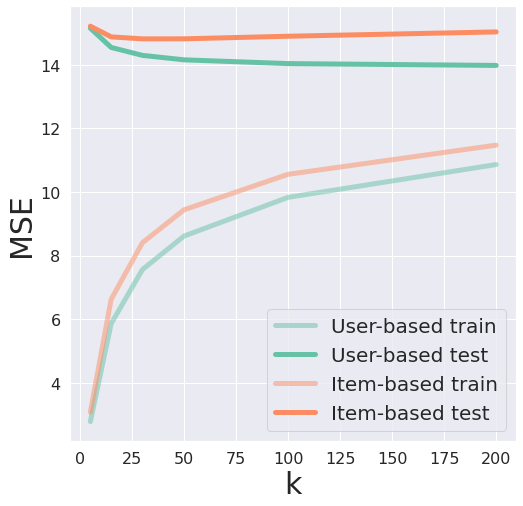

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [ ]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [ ]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print('Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_nobias(train, item_similarity, kind='item')
print('Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test)))

Bias-subtracted User-based CF MSE: 14.179765746223813
Bias-subtracted Item-based CF MSE: 14.618878318035934


In [ ]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [ ]:
pred = predict_topk_nobias(train, user_similarity, kind='user', k=25)
print('Bias-subtracted top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk_nobias(train, item_similarity, kind='item', k=25)
print('Bias-subtracted top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Bias-subtracted top-k User-based CF MSE: 14.402903312599806
Bias-subtracted top-k Item-based CF MSE: 14.576085397137716


In [ ]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

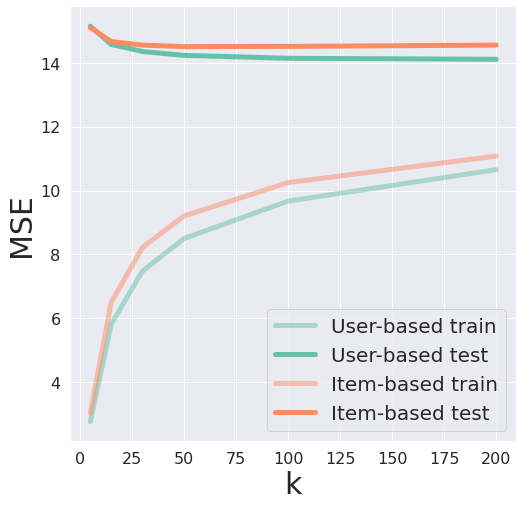

In [ ]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

##Word Clouds and some nlp

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
#cleaning

import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
def clean_text(text):

  text=str(text).lower()
  text=re.sub('\[.*?\]','', text)
  text=re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text=re.sub('\w*\d\w*', '', text)
  text=re.sub('[''""]','',text)
  text=re.sub('\n','',text)
  text=re.sub('[^\x00-\x7F]*','',text)
  text=re.sub('[^a-z 0-9]*','',text)
  return text

round1= lambda x: clean_text(x)

def get_name_from_id(index, df):
  return df[df.index==index]["name"].values[0]

def get_index_from_name(name):
  return df[df.name==name]["index"].values[0]

In [ ]:
from nltk import word_tokenize, pos_tag

def adjectives(text):
  is_adj = lambda pos: pos[:2]=='JJ'
  tokenized=word_tokenize(text)
  all_adj=[word for (word, pos) in pos_tag(tokenized) if is_adj(pos)]
  return ' '.join(all_adj)

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter_stemmer=PorterStemmer()

def stem_sentences(text):
  tokens=text.split()
  stemmed_tokens=[porter_stemmer.stem(token) for token in tokens]
  return ' '.join(stemmed_tokens)

In [ ]:
lemmatizer=WordNetLemmatizer()

def lemmatize(text):
  tokens=text.split()
  lemmatized_tokens=[lemmatizer.lemmatize(token) for token in tokens]
  return ' '.join(lemmatized_tokens)

In [ ]:
rest_reviews=pd.read_csv("/mydrive/DA_project/data/reviews_Cleveland_OH.csv")
print('dropping useless columnns')
rest_reviews.drop(['Unnamed: 0','Unnamed: 0.1', 'useful', 'funny', 'cool', 'date'], axis=1, inplace=True)
print('removing na')
for column in rest_reviews.columns:
  rest_reviews[column].fillna('',inplace=True)
rest_reviews.reset_index(inplace=True)
print('dropping useless reviews')
rest_reviews.text=rest_reviews.text.apply(round1)
#rest_reviews.text=rest_reviews.text.apply(check_english)
rest_reviews=rest_reviews[rest_reviews.text.str.len() > 5]

dropping useless columnns
removing na
dropping useless reviews


In [ ]:
df_restaurant=pd.read_csv("/mydrive/DA_project/data/rest_Cleveland_OH.csv")
df_restaurant=df_restaurant[['business_id','name','review_count','stars','categories']]
#10 worst restaurants
#df_temp=df_restaurant.sort_values(['stars','review_count'],ascending=[True,False]).head(10)
#10 more popular restaurants
df_temp=df_restaurant.sort_values(['review_count'],ascending=False).head(10)
df_temp.set_index(['business_id'])

,name,review_count,stars,categories
business_id,,,,
GIfZNMP0oIJCje_Xp0Bgrw,The Greenhouse Tavern,1104,3.5,"Breakfast & Brunch, Gastropubs, French, Restau..."
J1RDyyPxhioqm8c_fi4P4Q,Lola,1078,4.0,"American (New), Wine Bars, Restaurants, Nightl..."
meXjqyhTNLFmknY39y2sMg,Great Lakes Brewing Company,995,4.0,"Event Planning & Services, Breweries, Venues &..."
cX2Nr_XmGYlMaBW35M0sUg,Mabel's BBQ,974,4.0,"Barbeque, Restaurants, Nightlife, Bars"
_5PJ4GHIXNdUdXtohylKGQ,Lucky's Cafe,892,4.0,"Restaurants, Food, Breakfast & Brunch, Coffee ..."
F2pfjAZ_3dMTGCKv6c5wOw,Momocho,776,4.0,"Mexican, Restaurants"
SzcCJJmreMlWCsNjupdVAA,L'Albatros,679,4.5,"French, Restaurants"
vdloJPM3bSpQTMlwdFek2A,Butcher and the Brewer,676,4.0,"Food, Restaurants, Pubs, Bars, Beer, Wine & Sp..."
anzCdD5eIEHwydTpXhLlUA,Happy Dog,652,4.0,"Arts & Entertainment, Music Venues, Nightlife,..."


In [ ]:
rest_reviews.drop(['Unnamed: 0.1.1','review_id', 'user_id'], axis=1, inplace=True)

In [ ]:
rest_reviews.head()

,index,business_id,stars,text
0,0,bM3ARXFMxGrntnHS6a7vEQ,5.0,so i dont give out stars frivolously but this...
1,1,TKaND6oV1n2ylnCYoAfoag,5.0,the tacos i got pastor asada and chorizo authe...
2,2,bM3ARXFMxGrntnHS6a7vEQ,5.0,i must have walked by this place a thousand ti...
3,3,K74HYkFjYwhEpJt8HTOxnQ,5.0,we had an incredible time the food and atmosph...
4,4,4V2KN03EJMzaoOmLOy5UhQ,5.0,love this place at all times of the day they h...


In [ ]:
rest_reviews2=rest_reviews.groupby('business_id').agg({'text':' '.join,'stars':'mean'}).reset_index()

In [ ]:
rest_reviews2['text']=rest_reviews2['text'].apply(lemmatize)
rest_reviews2.to_csv("/mydrive/DA_project/data/dtm/temp.csv")

In [ ]:
rest_reviews2=rest_reviews2.set_index(['business_id'])

In [ ]:
rest_reviews_final=pd.DataFrame(rest_reviews2.text.apply(adjectives))

In [ ]:
rest_reviews_final.to_csv("/mydrive/DA_project/data/dtm/temp_adj.csv")

In [ ]:
#run this cell directy in case of session crash
rest_reviews_final=pd.read_csv("/mydrive/Yelp/city_reviews/dtm/temp_adj.csv")
rest_reviews_final=rest_reviews_final.set_index(['business_id'])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(stop_words='english')
data_cv=cv.fit_transform(rest_reviews_final.text)
data_dtm=pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index=rest_reviews_final.index
data_dtm

,aa,aaa,aaaaawful,aaaahhhhhhhhhhh,aaaallll,aaahmmaaaaziingg,aaawww,aai,aaloo,aamof,aaron,aarp,aatmosphere,abad,abandoned,abandonment,abatement,abba,abbey,abbondanza,abbot,abbreviated,abc,abcthe,abcxyzv,abd,abdominal,abercrombie,abhor,abhorrent,abigail,abigal,abita,abject,ablaze,able,abnormal,abominable,abouta,aboutentree,...,zapps,zatar,zb,ze,zealous,zen,zeppole,zero,zest,zestful,zestiest,zesty,zimbabwean,zimmern,zin,zinctopped,zingmixed,zingy,zip,ziplocked,zippy,ziti,zocalo,zodiacclassic,zoey,zoi,zombie,zombielike,zomg,zone,zoo,zooey,zoopolish,zu,zucchini,zumba,zunilike,zwei,zygote,zza
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-23R9P2eG7VTc6DVLjFKzA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-DU8jf5nA1_yaOqsKsLqmw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-DkhPijabXuTNvNteIpRPw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-F0B5F1YLx7093otwgboxw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-GQzMguGfB4jswo8jAO7CQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhwqX2uk3XF_fwtwLj397A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
zlBbV0XwfmRVSogHVDDmEw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
zo9fKM_Sty6qGztXKoMPmQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_dtm2 = data_dtm.loc[:, (data_dtm==0).mean() < .97]

In [ ]:
data_dtm2.to_csv("/mydrive/DA_project/data/dtm/tmp_97.csv")

In [ ]:
data_dtm2=data_dtm2.transpose()

In [ ]:
top_dict={}
for business in data_dtm2.columns:
  top=data_dtm2[business].sort_values(ascending=False).head(30)
  top_dict[business]=list(zip(top.index,top.values))
top_dict

{'-23R9P2eG7VTc6DVLjFKzA': [('good', 3),
  ('cheap', 1),
  ('pretentious', 1),
  ('great', 1),
  ('bad', 1),
  ('hometown', 1),
  ('local', 1),
  ('crazy', 1),
  ('cordial', 1),
  ('hard', 1),
  ('garlicky', 0),
  ('garlic', 0),
  ('garnish', 0),
  ('frozen', 0),
  ('general', 0),
  ('funny', 0),
  ('generic', 0),
  ('funky', 0),
  ('fun', 0),
  ('fry', 0),
  ('frustrating', 0),
  ('future', 0),
  ('yummy', 0),
  ('friendly', 0),
  ('friendliest', 0),
  ('formal', 0),
  ('fourth', 0),
  ('frank', 0),
  ('freakin', 0),
  ('free', 0)],
 '-DU8jf5nA1_yaOqsKsLqmw': [('good', 7),
  ('little', 3),
  ('fresh', 3),
  ('perfect', 2),
  ('daily', 2),
  ('italian', 2),
  ('bad', 2),
  ('great', 2),
  ('sure', 1),
  ('cold', 1),
  ('thankful', 1),
  ('sick', 1),
  ('delicious', 1),
  ('cheese', 1),
  ('cheap', 1),
  ('update', 1),
  ('awful', 1),
  ('damn', 1),
  ('exceptional', 1),
  ('small', 1),
  ('simple', 1),
  ('longer', 1),
  ('amazing', 1),
  ('red', 1),
  ('quick', 1),
  ('happy', 1),
  (

In [ ]:
for business,top_words in top_dict.items():
  if business in df_temp['business_id'].values:
    print(df_temp[df_temp.business_id==business].name)
    print(', '.join([word for word,count in top_words[0:30] if (len(word)>3)]))
    print('---')

719    Superior Pho
Name: name, dtype: object
good, superior, best, great, vietnamese, delicious, little, bubble, small, noodle, large, fresh, nice, favorite, better, asian, flavorful, authentic, friendly, different, quick, perfect, tasty, cold, sure
---
662    Momocho
Name: name, dtype: object
good, great, mexican, delicious, happy, best, guacamole, little, favorite, different, small, margarita, amazing, excellent, cheese, fresh, nice, sure, traditional, fantastic, awesome, unique, friendly, special, high, able
---
1377    The Greenhouse Tavern
Name: name, dtype: object
good, great, best, delicious, little, nice, small, tavern, favorite, happy, second, different, excellent, sure, local, dish, fresh, better, short, friendly, green, vegetarian, amazing, cool, fantastic, perfect, main
---
988    Lola
Name: name, dtype: object
good, great, delicious, best, nice, special, little, perfect, excellent, french, fantastic, amazing, better, entree, fresh, favorite, wonderful, sure, dish, overall

In [ ]:
from collections import Counter
words=[]
for business in data_dtm2.columns:
    top=[word for (word,count) in top_dict[business]]
    for t in top:
      words.append(t)

In [ ]:
from wordcloud import WordCloud

wc=WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)

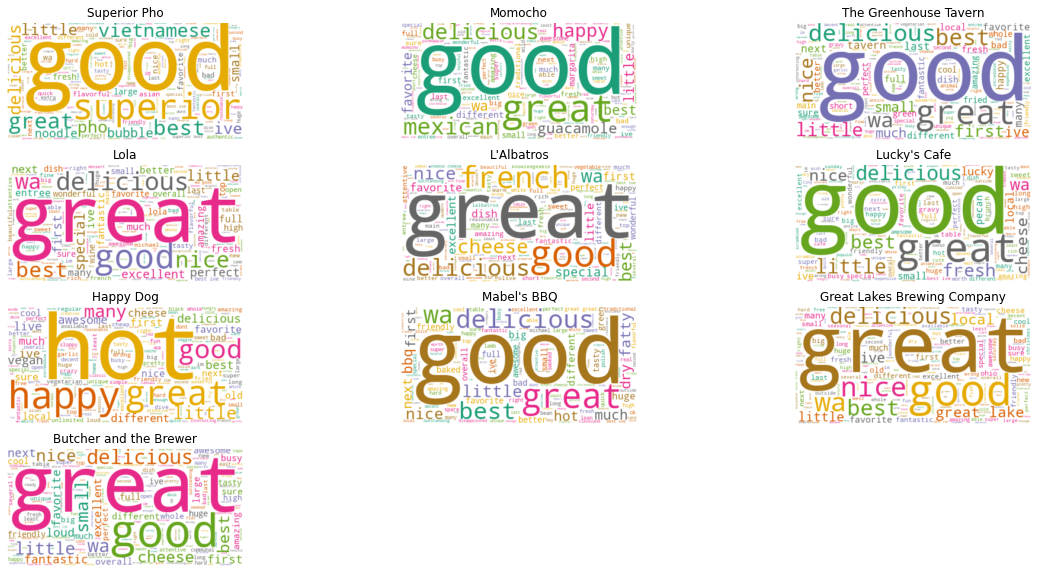

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[20,10]
plt.rcParams['text.color']='black'
businesses=df_temp['name'].values
i=0
for index, business in enumerate (data_dtm2.columns):
  if business in df_temp['business_id'].values:
    wc.generate(rest_reviews_final.text[business])
    plt.subplot(4,3,i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    title=df_temp.loc[df_temp['business_id']==business,'name'].iloc[0]
    plt.title(title)
    i+=1
plt.show()

##Sentiment Analysis

In [ ]:
df=pd.read_csv("/mydrive/DA_project/data/reviews_Cleveland_OH.csv")

In [ ]:
df.head()

,index,review_id,user_id,business_id,stars,text
0,0,3tsmExxS5NYBgqVfl2JOyg,ica-FXNzyDzoOeArmg9Lwg,bM3ARXFMxGrntnHS6a7vEQ,5.0,"So I don't give out 5 stars frivolously, but t..."
1,1,WEw6ymSk3N0LY4xLpvLWZg,ekO1FoeD8c9uqIQokBLCSQ,TKaND6oV1n2ylnCYoAfoag,5.0,"THE TACOS. I got pastor, asada, and chorizo. A..."
2,2,aR81GkM3Q9kcJbPxbBnuYw,DZEClXcmhoTk2caP9gpl5w,bM3ARXFMxGrntnHS6a7vEQ,5.0,I must have walked by this place a thousand ti...
3,3,LSPBfreF-ma3GbqEunb9iA,xEKAb9TGx4aOGbHXSaCmDQ,K74HYkFjYwhEpJt8HTOxnQ,5.0,We had an incredible time. The food and atmosp...
4,4,hdGYXYZU0Ku7MjW-nkRopg,w9wic5DqY79J-qWfF7mYQw,4V2KN03EJMzaoOmLOy5UhQ,5.0,Love this place at all times of the day. They ...


In [ ]:
df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1', 'useful','funny', 'cool', 'date'], axis=1, inplace=True)

In [ ]:
stats=df.describe()
stats

,stars
count,93576.000000
mean,3.774985
std,1.352174
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [ ]:
for column in df.columns:
  df[column].fillna(-1,inplace=True)  
df.reset_index(inplace=True)
df=df[df.stars > -1]
df=df[df.text!=-1]

In [ ]:
df.drop(['index'],axis=1,inplace=True)

In [ ]:
from textblob import TextBlob

pol= lambda x: TextBlob(x).sentiment.polarity
sub= lambda x: TextBlob(x).sentiment.subjectivity

df['polarity']= df['text'].apply(pol)
df['subjectivity']= df['text'].apply(sub)
df.head()

,review_id,user_id,business_id,stars,text,polarity,subjectivity
0,3tsmExxS5NYBgqVfl2JOyg,ica-FXNzyDzoOeArmg9Lwg,bM3ARXFMxGrntnHS6a7vEQ,5.0,"So I don't give out 5 stars frivolously, but t...",0.206349,0.419841
1,WEw6ymSk3N0LY4xLpvLWZg,ekO1FoeD8c9uqIQokBLCSQ,TKaND6oV1n2ylnCYoAfoag,5.0,"THE TACOS. I got pastor, asada, and chorizo. A...",0.565000,0.880000
2,aR81GkM3Q9kcJbPxbBnuYw,DZEClXcmhoTk2caP9gpl5w,bM3ARXFMxGrntnHS6a7vEQ,5.0,I must have walked by this place a thousand ti...,0.282593,0.599630
3,LSPBfreF-ma3GbqEunb9iA,xEKAb9TGx4aOGbHXSaCmDQ,K74HYkFjYwhEpJt8HTOxnQ,5.0,We had an incredible time. The food and atmosp...,0.866667,0.600000
4,hdGYXYZU0Ku7MjW-nkRopg,w9wic5DqY79J-qWfF7mYQw,4V2KN03EJMzaoOmLOy5UhQ,5.0,Love this place at all times of the day. They ...,0.760000,0.600000


In [ ]:
df.to_csv("/mydrive/DA_project/data/sentiment/reviews_Cleveland_OH.csv")

In [ ]:
stats=df.describe()
stats

,stars,polarity,subjectivity,subjectivity_2,subjectivity_3,polarity_2,review_stars
count,93576.000000,93576.000000,93576.000000,93576.000000,93576.000000,93576.000000,93576.000000
mean,3.774985,0.255159,0.575166,0.424834,0.939867,0.232483,0.616241
std,1.352174,0.227692,0.127582,0.127582,0.102066,0.197114,0.098557
min,1.000000,-1.000000,0.000000,0.000000,0.600000,-1.000000,0.000000
25%,3.000000,0.125110,0.500000,0.350000,0.880000,0.121594,0.560797
50%,4.000000,0.257862,0.572318,0.427682,0.942146,0.244536,0.622268
75%,5.000000,0.390274,0.650000,0.500000,1.000000,0.357883,0.678942
max,5.000000,1.000000,1.000000,1.000000,1.400000,1.000000,1.000000


(3000, 8)


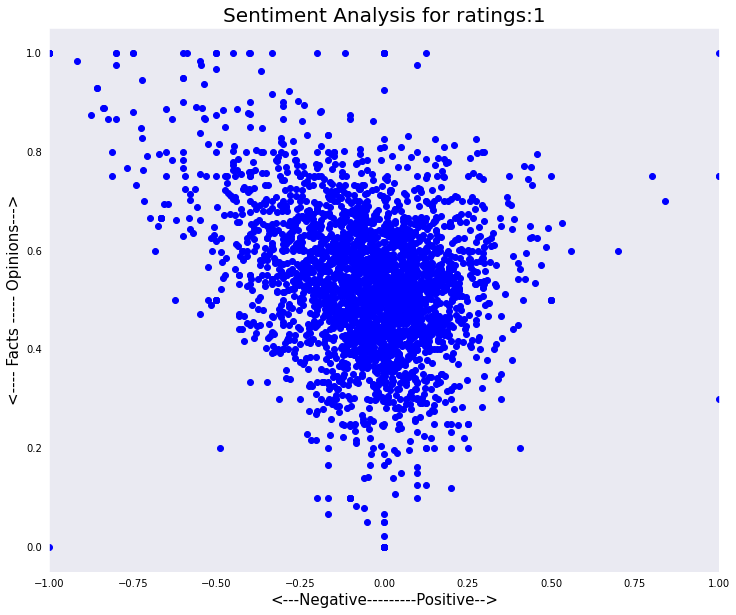

(3000, 8)


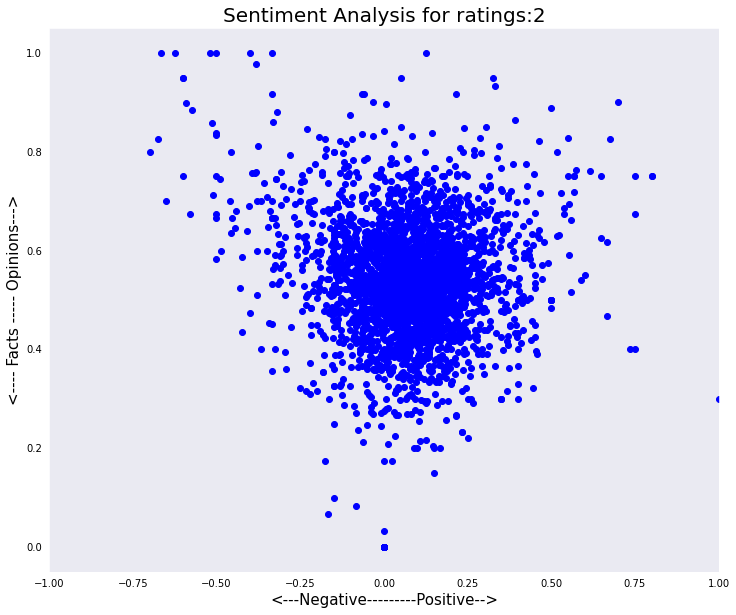

(3000, 8)


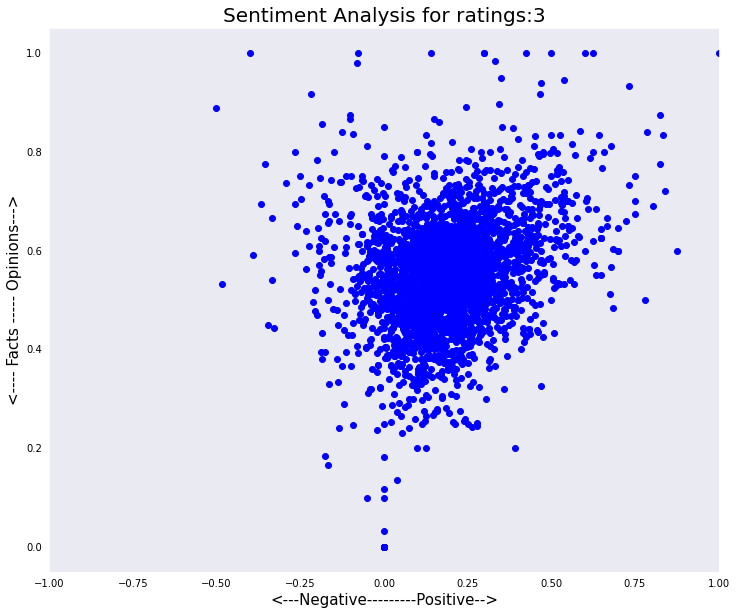

(3000, 8)


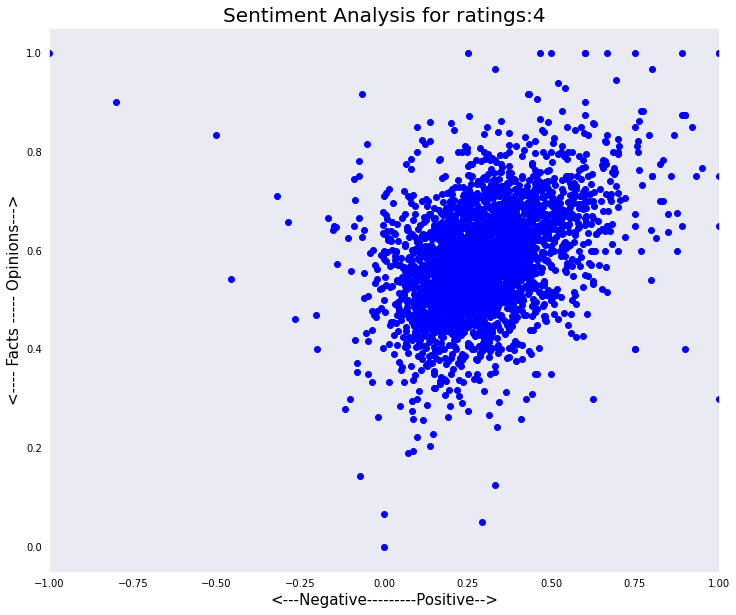

(3000, 8)


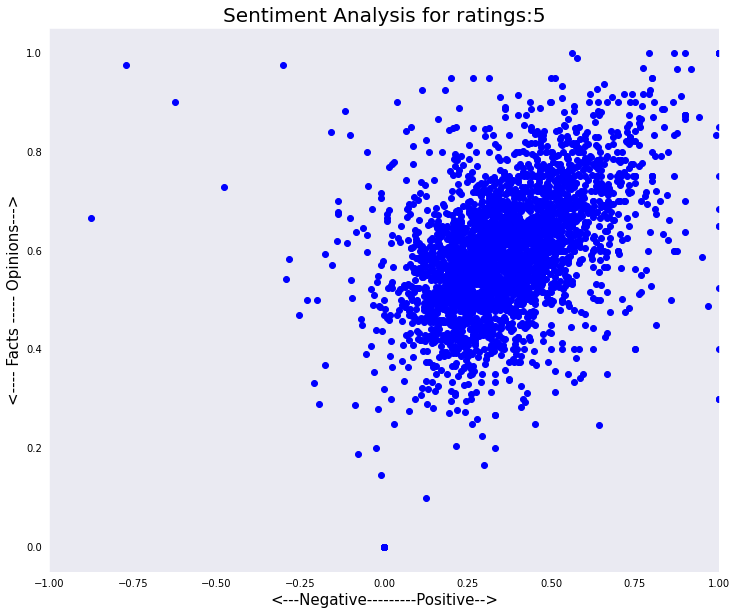

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12,10]
plt.rcParams['text.color']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['axes.labelcolor']='black'
for i in range(1,6):
  df_subset=df[df.stars==i]
  df_subset=df_subset.sample(n=3000)
  df_subset.reset_index(inplace=True)
  print(df_subset.shape)
  for index, review_id in enumerate(df_subset.index):
    #plt.subplot(3,2,i+1)
    x=df_subset.polarity.loc[review_id]
    y=df_subset.subjectivity.loc[review_id]
    plt.scatter(x,y, color='blue')
    plt.xlim(-1,1)
  plt.title('Sentiment Analysis for ratings:'+str(i), fontsize=20) 
  plt.xlabel('<---Negative---------Positive-->', fontsize=15)
  plt.ylabel('<---- Facts ----- Opinions--->', fontsize=15)
  plt.show()

In [ ]:
#new_value=(((old_value-old_min)* (NewMax - NewMin))/(OldMax-OldMin))+NewMin
new_range=lambda x: (((x-0)* (1.4 - 0.6))/(1-0))+0.6
switch=lambda x: 1-x

In [ ]:
#Creating a new range for subjectivity between 1.25 and 0.75 where 1.25 is a factual review and 0.75 is opinionated
df['subjectivity_2']= df['subjectivity'].apply(switch)
df['subjectivity_3']= df['subjectivity_2'].apply(new_range)

In [ ]:
df['polarity_2']=df.polarity*df.subjectivity_3
df.polarity_2.clip(-1,1, inplace=True)

In [ ]:
df['review_stars']=df.polarity_2 + 1
df['review_stars']=df.review_stars/2

In [ ]:
df.to_csv("/mydrive/DA_project/data/sentiment/final_reviews_Cleveland_OH.csv")

##Collaborative Filtering with WALS

In [ ]:
#Execute this for biased WALS
df=pd.read_csv("/mydrive/DA_project/data/reviews_Cleveland_OH.csv")


In [ ]:
df=pd.read_csv("/mydrive/DA_project/data/sentiment/final_reviews_Cleveland_OH.csv")
df.drop(['Unnamed: 0','text','review_id','polarity','subjectivity','subjectivity_2','subjectivity_3','polarity_2'], axis=1, inplace=True)

In [ ]:
for column in df.columns:
  df[column].fillna(-1,inplace=True)  
df.reset_index(inplace=True)
df=df[df.stars > -1]

In [ ]:
df.head()

,index,user_id,business_id,stars,review_stars
0,0,ica-FXNzyDzoOeArmg9Lwg,bM3ARXFMxGrntnHS6a7vEQ,5.0,0.609791
1,1,ekO1FoeD8c9uqIQokBLCSQ,TKaND6oV1n2ylnCYoAfoag,5.0,0.696620
2,2,DZEClXcmhoTk2caP9gpl5w,bM3ARXFMxGrntnHS6a7vEQ,5.0,0.630034
3,3,xEKAb9TGx4aOGbHXSaCmDQ,K74HYkFjYwhEpJt8HTOxnQ,5.0,0.898667
4,4,w9wic5DqY79J-qWfF7mYQw,4V2KN03EJMzaoOmLOy5UhQ,5.0,0.849600


In [ ]:
df['rating']=(df.stars-stats.loc['min','stars'])/(stats.loc['max','stars']-stats.loc['min','stars'])
#Execute this line if you're doing unbiased WALS
df['rating']=(df.rating+df.review_stars)/2

In [ ]:
del df['stars']
del df['review_stars']

In [ ]:
df.tail()

,index,user_id,business_id,rating
93571,93571,OnqpDePGI152EreaSlC1UQ,WuPSEvu8pES752S92awAVQ,0.197042
93572,93572,E2x1d2BZxUeV08p4ohYczg,xzQzJTu47vNCYlpB8jdMaw,0.276953
93573,93573,YGJ8jvKRMWLV5lz4AUWYyA,VXTReQT3Bqte_Liu58scdw,0.869167
93574,93574,zl4iUKPs-CpnH_0cPWJ02g,nqiTujxNtEpA8dPATEQRrg,0.266305
93575,93575,Iy6HkAzFcpeU7GF0e1FRSA,R13VkcyUIU3xG2fRFbBvBA,0.669141


###Create Mapping

In [ ]:
import numpy as np
def create_mapping(values, filename):
  with open(filename, 'w') as ofp:
    value_to_id={value:idx for idx,value in enumerate(values.unique())}
    for value, idx in value_to_id.items():
      idx=str(idx)
      ofp.write(value+','+idx+'\n')
    return value_to_id

user_mapping=create_mapping(df['user_id'], '/mydrive/DA_project/data/wals/users.csv')
item_mapping=create_mapping(df['business_id'], '/mydrive/DA_project/data/wals/items.csv')

In [ ]:
len(user_mapping)

39296

In [ ]:
df.head()
df.to_csv("/mydrive/DA_project/data/sentiment/ratings_Cleveland_OH.csv")

In [ ]:
df['userId']=df['user_id'].map(user_mapping.get)
df['itemId']=df['business_id'].map(item_mapping.get)

In [ ]:
mapped_df=df[['userId','itemId','rating']]
mapped_df.to_csv("/mydrive/DA_project/data/wals/collab_mapped.csv",index=False, header=False)
mapped_df.head()

,userId,itemId,rating
0,0,0,0.804895
1,1,1,0.848310
2,2,0,0.815017
3,3,2,0.949333
4,4,3,0.924800


In [ ]:
mapped_df.tail()

,userId,itemId,rating
93571,7605,1436,0.197042
93572,9237,1388,0.276953
93573,36841,1414,0.869167
93574,39295,1377,0.266305
93575,12544,1417,0.669141


###Creating the rows and columns datasets

In [ ]:
import pandas as pd
import numpy as np
mapped_df=pd.read_csv("/mydrive/DA_project/data/wals/collab_mapped.csv",header=None, names=['userId', 'itemId','rating'])

In [ ]:
mapped_df.head()

,userId,itemId,rating
0,0,0,0.804895
1,1,1,0.848310
2,2,0,0.815017
3,3,2,0.949333
4,4,3,0.924800


In [ ]:
NITEMS=np.max(mapped_df['itemId'])+1
NUSERS=np.max(mapped_df['userId'])+1
print(str(NITEMS)+" items, "+str(NUSERS)+" users, "+str(len(mapped_df))+" interactions")

1523 items, 39296 users, 93576 interactions


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
grouped_by_items=mapped_df.groupby('itemId')
with tf.python_io.TFRecordWriter('/mydrive/DA_project/data/wals/users_for_item') as ofp:
  for item, grouped in grouped_by_items:
    example=tf.train.Example(features=tf.train.Features(feature={
        'key': tf.train.Feature(int64_list=tf.train.Int64List(value=[item])),
        'indices': tf.train.Feature(int64_list=tf.train.Int64List(value=grouped['userId'].values)),
        'values': tf.train.Feature(float_list=tf.train.FloatList(value=grouped['rating'].values))
    }))
    ofp.write(example.SerializeToString())

In [ ]:
grouped_by_users=mapped_df.groupby('userId')
with tf.python_io.TFRecordWriter('/mydrive/DA_project/data/wals/items_for_user') as ofp:
  for user, grouped in grouped_by_users:
    example=tf.train.Example(features=tf.train.Features(feature={
        'key': tf.train.Feature(int64_list=tf.train.Int64List(value=[user])),
        'indices': tf.train.Feature(int64_list=tf.train.Int64List(value=grouped['itemId'].values)),
        'values': tf.train.Feature(float_list=tf.train.FloatList(value=grouped['rating'].values))
    }))
    ofp.write(example.SerializeToString())

In [ ]:
grouped_by_users=mapped_df.groupby('userId')
N=0
with tf.python_io.TFRecordWriter('/mydrive/DA_project/data/wals/items_for_user_subset') as ofp:
  for user, grouped in grouped_by_users:
    example=tf.train.Example(features=tf.train.Features(feature={
        'key': tf.train.Feature(int64_list=tf.train.Int64List(value=[user])),
        'indices': tf.train.Feature(int64_list=tf.train.Int64List(value=grouped['itemId'].values)),
        'values': tf.train.Feature(float_list=tf.train.FloatList(value=grouped['rating'].values))
    }))
    ofp.write(example.SerializeToString())
    N=N+1
    if N>20:
      break

In [ ]:
!ls -lrt /mydrive/DA_project/data/wals

total 7375
-rw------- 1 root root 1128474 Nov 30 00:21 users.csv
-rw------- 1 root root   41534 Nov 30 00:21 items.csv
-rw------- 1 root root 2513266 Nov 30 00:22 collab_mapped.csv
-rw------- 1 root root  695518 Nov 30 00:24 users_for_item
-rw------- 1 root root 3168822 Nov 30 00:24 items_for_user
-rw------- 1 root root    2095 Nov 30 00:25 items_for_user_subset


###WALS training

In [ ]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization

def read_dataset(mode, args):
  def decode_example(protos, vocab_size):
    features={'key': tf.FixedLenFeature([1], tf.int64),
              'indices': tf.VarLenFeature(dtype=tf.int64),
              'values':tf.VarLenFeature(dtype=tf.float32)}
    parsed_features=tf.parse_single_example(protos, features)
    values=tf.sparse_merge(parsed_features['indices'], parsed_features['values'], vocab_size=vocab_size)
    #need to remap the key after batching
    key=parsed_features['key']
    decoded_sparse_tensor=tf.SparseTensor(indices=tf.concat([values.indices, [key]], axis=0),
                                          values=tf.concat([values.values, [0.0]], axis=0),
                                          dense_shape=values.dense_shape)
    return decoded_sparse_tensor

  def remap_keys(sparse_tensor):
    # Current indices of our SparseTensor that we need to fix
    bad_indices = sparse_tensor.indices
    # Current values of our SparseTensor that we need to fix
    bad_values = sparse_tensor.values 
  
    # Group by the batch_indices and get the count for each  
    size = tf.segment_sum(data = tf.ones_like(bad_indices[:,0], dtype = tf.int64), segment_ids = bad_indices[:,0]) - 1
    # The number of batch_indices (this should be batch_size unless it is a partially full batch)
    length = tf.shape(size, out_type = tf.int64)[0]
    # Finds the cumulative sum which we can use for indexing later
    cum = tf.cumsum(size)
    # The offsets between each example in the batch due to our concatentation of the keys in the decode_example method
    length_range = tf.range(start = 0, limit = length, delta = 1, dtype = tf.int64)
    # Indices of the SparseTensor's indices member of the rows we added by the concatentation of our keys in the decode_example method
    cum_range = cum + length_range

    # The keys that we have extracted back out of our concatentated SparseTensor
    gathered_indices = tf.squeeze(tf.gather(bad_indices, cum_range)[:,1])

    # The enumerated row indices of the SparseTensor's indices member
    sparse_indices_range = tf.range(tf.shape(bad_indices, out_type = tf.int64)[0], dtype = tf.int64)

    # We want to find here the row indices of the SparseTensor's indices member that are of our actual data and not the concatentated rows
    # So we want to find the intersection of the two sets and then take the opposite of that
    x = sparse_indices_range
    s = cum_range

    # Number of multiples we are going to tile x, which is our sparse_indices_range
    tile_multiples = tf.concat([tf.ones(tf.shape(tf.shape(x)), dtype=tf.int64), tf.shape(s, out_type = tf.int64)], axis = 0)
    # Expands x, our sparse_indices_range, into a rank 2 tensor and then multiplies the rows by 1 (no copying) and the columns by the number of examples in the batch
    x_tile = tf.tile(tf.expand_dims(x, -1), tile_multiples)
    # Essentially a vectorized logical or, that we then negate
    x_not_in_s = ~tf.reduce_any(tf.equal(x_tile, s), -1)

    # The SparseTensor's indices that are our actual data by using the boolean_mask we just made above applied to the entire indices member of our SparseTensor
    selected_indices = tf.boolean_mask(tensor = bad_indices, mask = x_not_in_s, axis = 0)
    # Apply the same boolean_mask to the entire values member of our SparseTensor to get the actual values data
    selected_values = tf.boolean_mask(tensor = bad_values, mask = x_not_in_s, axis = 0)

    # Need to replace the first column of our selected_indices with keys, so we first need to tile our gathered_indices
    tiling = tf.tile(input = tf.expand_dims(gathered_indices[0], -1), multiples = tf.expand_dims(size[0] , -1))
    
    # We have to repeatedly apply the tiling to each example in the batch
    # Since it is jagged we cannot use tf.map_fn due to the stacking of the TensorArray, so we have to create our own custom version
    def loop_body(i, tensor_grow):
      return i + 1, tf.concat(values = [tensor_grow, tf.tile(input = tf.expand_dims(gathered_indices[i], -1), multiples = tf.expand_dims(size[i] , -1))], axis = 0)

    _, result = tf.while_loop(lambda i, tensor_grow: i < length, loop_body, [tf.constant(1, dtype = tf.int64), tiling])
    
    # Concatenate tiled keys with the 2nd column of selected_indices
    selected_indices_fixed = tf.concat([tf.expand_dims(result, -1), tf.expand_dims(selected_indices[:, 1], -1)], axis = 1)
    
    # Combine everything together back into a SparseTensor
    remapped_sparse_tensor = tf.SparseTensor(indices = selected_indices_fixed, values = selected_values, dense_shape = sparse_tensor.dense_shape)
    return remapped_sparse_tensor

    
  def parse_tfrecords(filename, vocab_size):
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
    else:
        num_epochs = 1 # end-of-input after this
    
    files = tf.gfile.Glob(os.path.join(args['input_path'], filename))
    
    # Create dataset from file list
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(lambda x: decode_example(x, vocab_size))
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(args['batch_size'])
    dataset = dataset.map(lambda x: remap_keys(x))
    return dataset.make_one_shot_iterator().get_next()
  
  def _input_fn():
    features = {
      WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords('items_for_user', args['nitems']),
      WALSMatrixFactorization.INPUT_COLS: parse_tfrecords('users_for_item', args['nusers']),
      WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
    }
    return features, None
  
  def _input_fn_subset():
    features={
        WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords('items_for_user_subset', args['nitems']),
        WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
    }
    return features, None

  def input_cols():
    return parse_tfrecords('users_for_item', args['nusers'])
  
  return _input_fn


In [ ]:
def try_out():
  with tf.Session() as sess:
    fn = read_dataset(tf.estimator.ModeKeys.EVAL,
                      {'input_path':'/mydrive/DA_project/data/wals', 'batch_size': 8, 'nitems':1523,'nusers':39296 })
    feats, _=fn()
    print(feats['input_rows'].eval())

try_out()

SparseTensorValue(indices=array([[   0,    0],
       [   1,    1],
       [   1,  191],
       [   1, 1240],
       [   2,    0],
       [   2,  206],
       [   2,  327],
       [   3,    2],
       [   4,    3],
       [   4,  489],
       [   4,  988],
       [   5,    4],
       [   5,  784],
       [   6,    5],
       [   6,   14],
       [   6,   34],
       [   6,   69],
       [   6,  184],
       [   6,  185],
       [   6,  195],
       [   6,  451],
       [   6,  462],
       [   6,  467],
       [   6,  483],
       [   6,  486],
       [   6,  625],
       [   6,  629],
       [   6,  633],
       [   6,  638],
       [   6,  652],
       [   6,  653],
       [   6,  710],
       [   6,  777],
       [   6,  778],
       [   6,  918],
       [   6,  924],
       [   6,  952],
       [   6, 1394],
       [   7,    6]]), values=array([0.80489546, 0.84831   , 0.8332639 , 0.8444441 , 0.8150172 ,
       0.88346916, 0.8412013 , 0.9493333 , 0.9248    , 0.83893365,
       0.653

In [ ]:
def find_top_k(user, item_factors, k):
  all_items = tf.matmul(tf.expand_dims(user, 0), tf.transpose(item_factors))
  topk= tf.nn.top_k(all_items, k=k)
  return tf.cast(topk.indices, dtype=tf.int64)

def batch_predict(args):
  import numpy as np
  with tf.Session() as sess:
    estimator=tf.contrib.factorization.WALSMatrixFactorization(
        num_rows=args['nusers'], num_cols=args['nitems'],
        embedding_dimension=args['n_embeds'],
        model_dir=args['output_dir'])
    
    user_factors= tf.convert_to_tensor(estimator.get_row_factors()[0])
    item_factors= tf.convert_to_tensor(estimator.get_col_factors()[0])

    topk= tf.squeeze(tf.map_fn(lambda user: find_top_k(user, item_factors, args['topk']), user_factors, dtype=tf.int64))
    with file_io.FileIO(os.path.join(args['output_dir'], 'batch_pred.txt'), mode='w') as f:
      for best_items_for_user in topk.eval():
        f.write(','.join(str(x) for x in best_items_for_user)+'\n')

def create_serving_input_fn(args):
  def for_user_embeddings(userId):
    items=tf.range(args['nitems'], dtype=tf.int64)
    users=userId * tf.ones([args['nitems']], dtype=tf.int64)
    ratings= 0.1 * tf.ones_like(users, dtype=tf.float32)
    return items, users, ratings, tf.constant(True)
  
  def for_item_embeddings(itemId):
    users=tf.range(args['nusers'], dtype=tf.int64)
    items=itemId * tf.ones([args['nusers']], dtype=tf.int64)
    ratings= 0.1 * tf.ones_like(users, dtype=tf.float32)
    return items, users, ratings, tf.constant(False)

  def serving_input_fn():
    feature_ph={
        'userId': tf.placeholder(tf.int64, 1),
        'itemId': tf.placeholder(tf.int64, 1)
    }
    (items, users, ratings, project_row)= tf.cond(feature_ph['userId'][0]< tf.constant(0, dtype=tf.int64),
                                                  lambda: for_item_embeddings(feature_ph['itemId']),
                                                  lambda: for_user_embeddings(feature_ph['userId']))
    rows=tf.stack([users, items], axis=1)
    cols=tf.stack([items, users], axis=1)
    input_rows = tf.SparseTensor(rows, ratings, (args['nusers'], args['nitems']))
    input_cols = tf.SparseTensor(cols, ratings, (args['nusers'], args['nitems']))

    features={
      WALSMatrixFactorization.INPUT_ROWS: input_rows,
      WALSMatrixFactorization.INPUT_COLS: input_cols,
      WALSMatrixFactorization.PROJECT_ROW: project_row
    }
    return tf.contrib.learn.InputFnOps(features, None, feature_ph)
  return serving_input_fn

def train_and_evaluate(args):
  train_steps= int(0.5 + (1.0 * args['num_epochs'] * args['nusers']) / args['batch_size'])
  steps_in_epoch = int(0.5 + args['nusers'] / args['batch_size'])
  print('Will train for '+ str(train_steps)+' evaluating once every '+str(steps_in_epoch)+' steps')
  def experiment_fn(output_dir):
    return tf.contrib.learn.Experiment(
        tf.contrib.factorization.WALSMatrixFactorization(
            num_rows=args['nusers'], num_cols=args['nitems'],
            embedding_dimension=args['n_embeds'],
            model_dir=args['output_dir']),
        train_input_fn = read_dataset(tf.estimator.ModeKeys.TRAIN, args),
        eval_input_fn = read_dataset(tf.estimator.ModeKeys.EVAL, args),
        train_steps = train_steps,
        eval_steps=1,
        min_eval_frequency=steps_in_epoch,
        export_strategies=tf.contrib.learn.utils.saved_model_export_utils.make_export_strategy(serving_input_fn=create_serving_input_fn(args))        
    )
  from tensorflow.contrib.learn.python.learn import learn_runner
  learn_runner.run(experiment_fn, args['output_dir'])

  batch_predict(args)

In [ ]:
import shutil
shutil.rmtree('wals_trained', ignore_errors=True)
train_and_evaluate({
    'output_dir':'/mydrive/DA_project/data/wals/trained',
    'input_path':'/mydrive/DA_project/data/wals/',
    'num_epochs': 100,
    'nitems':1523,
    'nusers':39296,
    'batch_size': 512,
    'n_embeds': 10,
    'topk': 5
    })

Will train for 7675 evaluating once every 77 steps
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb2064b5ba8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/mydrive/DA_project/data/wals/trained', '_session_creation_timeout_secs': 7200}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was fi

In [ ]:
!ls /mydrive/DA_project/data/wals/trained

batch_pred.txt
checkpoint
eval
events.out.tfevents.1606696063.6cf293f5b68d
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-3838.data-00000-of-00001
model.ckpt-3838.index
model.ckpt-3838.meta


In [ ]:
!head /mydrive/DA_project/data/wals/trained/batch_pred.txt

483,0,184,677,457
914,1,916,189,920
483,677,206,641,184
647,625,473,365,637
489,483,184,488,1122
634,784,625,916,914
652,16,467,625,780
6,918,488,452,781
942,778,16,472,467
1235,1368,935,1082,199


##Extracting recommendations

In [ ]:
pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)

In [ ]:
f=open("/mydrive/DA_project/data/wals/trained/batch_pred.txt","r")

In [ ]:
lines=f.readlines()

In [ ]:
recommendations={}
i=0
for line in lines:
  data=line.rstrip().split(',')
  recommendations[i]=data
  i+=1
#recommendations

In [ ]:
data_items=recommendations.items()
data_list=list(data_items)
data_list
recommendations=pd.DataFrame(data_list)

In [ ]:
recommendations.rename(columns={0:'user_index',1:'recommendations'}, inplace=True)
recommendations.head()

,user_index,recommendations
0,0,"[0, 483, 185, 677, 778]"
1,1,"[914, 1, 916, 189, 199]"
2,2,"[483, 184, 206, 641, 677]"
3,3,"[647, 473, 677, 472, 1246]"
4,4,"[489, 184, 23, 921, 483]"


In [ ]:
user_df=pd.read_csv("/mydrive/DA_project/data/wals/users.csv",header=None, names=['user_id','user_index'])
user_df.head()

,user_id,user_index
0,ica-FXNzyDzoOeArmg9Lwg,0
1,ekO1FoeD8c9uqIQokBLCSQ,1
2,DZEClXcmhoTk2caP9gpl5w,2
3,xEKAb9TGx4aOGbHXSaCmDQ,3
4,w9wic5DqY79J-qWfF7mYQw,4


In [ ]:
item_df=pd.read_csv("/mydrive/DA_project/data/wals/items.csv",header=None, names=['business_id','item_index'])
item_df.head()

,business_id,item_index
0,bM3ARXFMxGrntnHS6a7vEQ,0
1,TKaND6oV1n2ylnCYoAfoag,1
2,K74HYkFjYwhEpJt8HTOxnQ,2
3,4V2KN03EJMzaoOmLOy5UhQ,3
4,GtSNTE2qMOZBlj0noCgCGw,4


In [ ]:
print(user_df.shape, item_df.shape)

(39296, 2) (1523, 2)


In [ ]:
recommendations

,user_index,recommendations
0,0,"[0, 483, 185, 677, 778]"
1,1,"[914, 1, 916, 189, 199]"
2,2,"[483, 184, 206, 641, 677]"
3,3,"[647, 473, 677, 472, 1246]"
4,4,"[489, 184, 23, 921, 483]"
...,...,...
39291,39291,"[1368, 1268, 916, 632, 773]"
39292,39292,"[1257, 927, 939, 23, 921]"
39293,39293,"[637, 656, 17, 331, 1376]"
39294,39294,"[916, 486, 470, 481, 191]"


In [ ]:
recommendations['user_id']=user_df.user_id[user_df.user_index==recommendations.user_index]

In [ ]:
recommendations.head()
recommendations.to_csv('/mydrive/DA_project/data/demo/recommendations_Cleveland_OH.csv')

In [ ]:
ratings_df=pd.read_csv('/mydrive/DA_project/data/sentiment/ratings_Cleveland_OH.csv')
ratings_df.head()

,Unnamed: 0,index,user_id,business_id,rating,userId,itemId
0,0,0,ica-FXNzyDzoOeArmg9Lwg,bM3ARXFMxGrntnHS6a7vEQ,0.804895,0,0
1,1,1,ekO1FoeD8c9uqIQokBLCSQ,TKaND6oV1n2ylnCYoAfoag,0.848310,1,1
2,2,2,DZEClXcmhoTk2caP9gpl5w,bM3ARXFMxGrntnHS6a7vEQ,0.815017,2,0
3,3,3,xEKAb9TGx4aOGbHXSaCmDQ,K74HYkFjYwhEpJt8HTOxnQ,0.949333,3,2
4,4,4,w9wic5DqY79J-qWfF7mYQw,4V2KN03EJMzaoOmLOy5UhQ,0.924800,4,3


In [ ]:
business_df=pd.read_csv("/mydrive/DA_project/data/rest_Cleveland_OH.csv")

In [ ]:
def getRecommendations(userId):
  #subset all reviews with userId
  subset_df=ratings_df[ratings_df.user_id==userId]
  #create list of businesses that user has reviewed well
  likes=list(subset_df.business_id[subset_df.rating>0.6])
  liked_business=business_df[business_df.business_id.isin(likes)]
  liked_business.sort_values(['stars', 'review_count'], ascending=[False, False])
  print("Here are some restaurants you seemed to like")
  if len(likes)>0 and len(likes)<6:
    print(liked_business[['name','stars','categories']])
    #print(likes)
  elif len(likes)>5:
    print(liked_business[['name','stars','categories']].head(5))
  else:
    print("You dont seem to have liked any restaurants yet, here are some recommendations you might like")
  #extract all recommended business ids
  rec_list=recommendations.recommendations[recommendations.user_id==userId].values
  #print(rec_list[0])
  business_list=[]
  for i in rec_list[0]:
    i=int(i)
    business_list.extend(item_df.business_id[item_df.item_index==i].values)
  #print(business_list)
  #print(liked_business.shape)
  recommended_business=business_df[business_df.business_id.isin(business_list)]
  #print(recommended_business.shape)
  print("\n\n\n")
  print("Users who visited the same restaurants as you also seemed to like these:")
  print(recommended_business[['name','stars','categories']])
  '''
  print(liked_business.head())
  print(recommended_business.head())'''

**Here are some user ids you might want to try out:**
1. nOr3_aq60yivqgcso_iDMw
2. RylA6VZUTRuMGBu4nHKbCw
3. dt9IHwfuZs9D9LOH7gjNew
4. NfU0zDaTMEQ4-X9dbQWd9A
5. Xxvz5g67eaCr3emnkY5M6w



In [ ]:
getRecommendations('NfU0zDaTMEQ4-X9dbQWd9A')

Here are some restaurants you seemed to like
                    name  ...                                                              categories
5   Bogtrotters Doorstep  ...  Restaurants, Sandwiches                                               
10  The Black Pig         ...  Restaurants, Food, American (New), French                             
12  Nano Brew             ...  Restaurants, American (New), Bars, Nightlife, Food, Breweries, Burgers
17  El Jalapeños          ...  Restaurants, Food, Mexican                                            
30  Phoenix Coffee        ...  Coffee & Tea, Restaurants, Food                                       

[5 rows x 3 columns]




Users who visited the same restaurants as you also seemed to like these:
                                name  ...                                                                                                categories
291  Johnny Mango World Cafe & Bar    ...  Mexican, Juice Bars & Smoothies, Vegetarian, American